In [1]:
import tensorflow as tf

In [2]:
from keras.optimizers import Adam

In [3]:
import dlmodels

In [4]:
import tensorflow.keras.models as models

In [5]:
import tensorflow.keras.optimizers as optimizers

In [6]:
import tensorflow.keras.utils as kutils

In [7]:
import sklearn.ensemble

In [8]:
import sklearn.metrics

In [9]:
import rasterio

In [10]:
import matplotlib.pyplot as plt

In [11]:
import numpy as np

In [12]:
import pandas

In [13]:
import os

In [14]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
SEED = 42
np.random.seed(SEED)

In [16]:
import keras
from keras import losses
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten


In [17]:
from fusion import create_model

In [18]:
#import fusion  ######改成py！！！！

In [19]:
#####optical

In [20]:
import os

# 定义数据集目录
BASE_DIR = "/home/jovyan/private/thesis_data/code/final_code/dataset"
# 假设您有三个不同的目录，分别存储不同类型的图像
S1_IMAGE_DIR = os.path.join(BASE_DIR, "sentinel1_images")
S2_10_IMAGE_DIR = os.path.join(BASE_DIR, "sentinel2_10_images")
S2_20_IMAGE_DIR = os.path.join(BASE_DIR, "sentinel2_20_images")
GEDI_IMAGE_DIR = os.path.join(BASE_DIR, "gedi_images")
LABEL_250_DIR = os.path.join(BASE_DIR, "LABEL_250_DIR")
LABEL_100_DIR = os.path.join(BASE_DIR, "LABEL_100_DIR")


# 定义常量

BATCH_SIZE = 1
EPOCHS = 50
STEPS = 20

# 定义测试和验证图像的文件名
# 假设每种类型的图像都有相同的命名方式
TRAIN_IMAGES = ["2.tif", "7.tif", "4.tif", "5.tif", "9.tif"]
VAL_IMAGES = ["6.tif", "3.tif"]
TEST_IMAGES = ["8.tif"]



In [21]:
patch_sizes = {"s1": (224, 224), "s2_10": (224, 224),"s2_20":(112,112), "gedi": (28, 28), "LABEL_250_DIR": (9, 9), "LABEL_100_DIR": (23, 23)}
bands_count = {"s1": 6, "s2_10": 4,"s2_20":6,"gedi":5 }
label_dirs = ['LABEL_250_DIR', 'LABEL_100_DIR']


In [22]:
#####read multiband image

In [23]:
# def read_and_preprocess_image(image_path, normalise_percentiles=NORMALISE_PERCENTILES):
#     with rasterio.open(image_path) as image_file:
#         image_arr = image_file.read()  # Reads all bands
#         if normalise_percentiles:
#             for band in range(image_arr.shape[0]):
#                 band_arr = image_arr[band]
#                 min_value = np.percentile(band_arr, normalise_percentiles[0])
#                 max_value = np.percentile(band_arr, normalise_percentiles[1])
#                 image_arr[band] = (band_arr - min_value) / (max_value - min_value)
#     return image_arr.transpose(1, 2, 0)  # Reorder dimensions to height x width x bands



In [24]:
# def apply_template(image_arr, template):
#     template_mask = np.all(template == 0, axis=-1)  # 创建模板遮罩
#     for band in range(image_arr.shape[0]):
#         band_arr = image_arr[band, :, :]
#         band_arr[template_mask] = 0  # 应用模板遮罩
#         image_arr[band, :, :] = band_arr
#     return image_arr

In [25]:
def read_and_preprocess_image(image_path, normalise_percentiles=(2, 98), is_complex=False):
    with rasterio.open(image_path) as image_file:
        image_arr = image_file.read()  # 以[通道, 高度, 宽度]格式读取所有波段
       
        image_arr[image_arr == image_file.nodata] = np.nan
                # 如果提供了模板，则应用模板
        # if template is not None:
        #     image_arr = apply_template(image_arr, template)
        
        if normalise_percentiles:
            for band in range(image_arr.shape[0]):
                band_arr = image_arr[band, :, :]
                min_value = np.nanpercentile(band_arr, normalise_percentiles[0])
                max_value = np.nanpercentile(band_arr, normalise_percentiles[1])
                if max_value - min_value > np.finfo(float).eps:
                    image_arr[band, :, :] = (band_arr - min_value) / (max_value - min_value)
                else:
                    image_arr[band, :, :] = np.zeros_like(band_arr)
                    
                    
        if is_complex:
            # 对于复数数据的特殊处理
            real_channel_1 = np.expand_dims(image_arr[0], axis=0)  # 第一个通道，扩展维度以便堆叠
            imag_channel_1 = np.zeros_like(real_channel_1)  # 第一个通道的虚部，使用零填充
            
            complex_real = np.expand_dims(image_arr[1], axis=0)  # 第二个通道作为复数的实部
            complex_imag = np.expand_dims(image_arr[2], axis=0)  # 第三个通道作为复数的虚部
            
            real_channel_4 = np.expand_dims(image_arr[3], axis=0)  # 第四个通道
            imag_channel_4 = np.zeros_like(real_channel_4)  # 第四个通道的虚部，使用零填充
            
            # 沿通道轴堆叠以创建6个通道
            image_arr = np.concatenate([real_channel_1, imag_channel_1, complex_real, complex_imag, real_channel_4, imag_channel_4], axis=0)

        # 在返回之前将 NaN 和 Inf 转换为 0
        # 此处 posinf 和 neginf 参数可用于指定用于替换正、负无穷的值；默认行为是用最大或最小的浮点数替换
        image_arr = np.nan_to_num(image_arr, nan=0.0, posinf=None, neginf=None)

    return image_arr.transpose(1, 2, 0)  # 重新排序维度为高度 x 宽度 x 通道


In [26]:

def read_single_band_image(image_path, normalise_percentiles=(2, 98)):
    with rasterio.open(image_path) as image_file:
        image_arr = image_file.read(1)  # Reads the first band
        
        # Checks and replaces nodata values with np.nan
        if image_file.nodata is not None:
            image_arr[image_arr == image_file.nodata] = np.nan
        
        # Applies normalization if needed
        if normalise_percentiles:
            min_value = np.nanpercentile(image_arr, normalise_percentiles[0])
            max_value = np.nanpercentile(image_arr, normalise_percentiles[1])
            if max_value - min_value > np.finfo(float).eps:
                image_arr = (image_arr - min_value) / (max_value - min_value)
            else:
                image_arr = np.zeros_like(image_arr)
        
        # Converts np.nan to 0.0
        single_band_image = np.nan_to_num(image_arr, nan=0.0)
    
    # Adds a channel dimension and returns
    return np.expand_dims(single_band_image, axis=-1)


In [27]:
#反归一化：在某些情况下，特别是回归问题中，你可能需要将预测结果“反归一化”回原始的数值范围，以便结果更易于理解和使用。这要求保存归一化过程中使用的参数（如最小值和最大值），以便在预测后进行逆操作。

In [28]:
# This function pads an image to the nearest size divisible by patch_size
# def pad_image_to_patch_size(image, patch_size=PATCH_SIZE):
#     height, width, _ = image.shape
#     target_height = patch_size * (height // patch_size + (height % patch_size > 0))
#     target_width = patch_size * (width // patch_size + (width % patch_size > 0))
#     pad_height = (target_height - height) // 2
#     pad_width = (target_width - width) // 2
#     padded_image = np.pad(image, ((pad_height, target_height - height - pad_height),
#                                   (pad_width, target_width - width - pad_width),
#                                   (0, 0)), mode='constant', constant_values=0)
#     return padded_image

In [29]:
#####别忘了patch

In [30]:
def pad_image_to_patch_size(image, patch_size):
    height, width, depth = image.shape
    patch_height, patch_width = patch_size  # 解包元组，分别获取补丁的高度和宽度

    # 计算目标高度和宽度
    target_height = patch_height * (height // patch_height + (1 if height % patch_height != 0 else 0))
    target_width = patch_width * (width // patch_width + (1 if width % patch_width != 0 else 0))

    # 计算填充量
    pad_height = (target_height - height) // 2
    pad_width = (target_width - width) // 2

    # 创建填充后的图像
    padded = np.zeros((target_height, target_width, depth), dtype=image.dtype)
    padded[pad_height:pad_height + height, pad_width:pad_width + width, :] = image

    return padded, (pad_height, pad_width)


In [31]:
class TrainSequence(kutils.Sequence):
    def __init__(self, filenames, batch_size, patch_sizes, bands_count, len, label_dirs):
        self.filenames = filenames
        self.batch_size = batch_size
        self.patch_sizes = patch_sizes  # 字典，包含每种图像和标签的补丁大小
        self.bands_count = bands_count  # 字典，包含每种图像类型的波段数
        self.len = len
        self.label_dirs = ['LABEL_250_DIR', 'LABEL_100_DIR']  # 列表，包含标签的目录
        self.read_dataset()

    def read_dataset(self):
        self.data = []
        for filename in self.filenames:
            # 读取和处理图像
            s1_image_path = os.path.join(S1_IMAGE_DIR, filename)
            s2_10_image_path = os.path.join(S2_10_IMAGE_DIR, filename)
            s2_20_image_path = os.path.join(S2_20_IMAGE_DIR, filename)
            gedi_image_path = os.path.join(GEDI_IMAGE_DIR, filename)
            
            #s1_image = read_and_preprocess_image(s1_image_path, normalise=True)
            s1_image = read_and_preprocess_image(s1_image_path, is_complex=True)

            # 然后处理其他图像，并使用S1图像作为模板
            s2_10_image = read_and_preprocess_image(s2_10_image_path)
            s2_20_image = read_and_preprocess_image(s2_20_image_path)
            gedi_image = read_and_preprocess_image(gedi_image_path)
            
            # Pad each image according to its patch size
            s1_image, _ = pad_image_to_patch_size(s1_image, self.patch_sizes['s1'])
            s2_10_image, _ = pad_image_to_patch_size(s2_10_image, self.patch_sizes['s2_10'])
            s2_20_image, _ = pad_image_to_patch_size(s2_20_image, self.patch_sizes['s2_20'])
            gedi_image, _ = pad_image_to_patch_size(gedi_image, self.patch_sizes['gedi'])


            images = {'s1': s1_image, 's2_10': s2_10_image, 's2_20':s2_20_image, 'gedi': gedi_image}

            # 读取和处理标签
            labels = []
            for label_type in self.label_dirs:
                label_path = os.path.join(BASE_DIR, label_type, filename)
                label = read_single_band_image(label_path)
                # 使用 label_type 作为键来获取对应的补丁大小
                label, _ = pad_image_to_patch_size(label, self.patch_sizes[label_type])
                labels.append(label)


            self.data.append((images, labels))

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        batch_x = {key: np.empty((self.batch_size, *self.patch_sizes[key], self.bands_count[key])) for key in ['s1', 's2_10', 's2_20','gedi']}
        batch_y = [np.empty((self.batch_size, *self.patch_sizes[label_dir], 1)) for label_dir in self.label_dirs]

        for patch_index in range(self.batch_size):
            images, labels = self.sample_image()
            patch_images = {key: self.sample_patch(image, self.patch_sizes[key]) for key, image in images.items()}
            patch_labels = [self.sample_patch(label, self.patch_sizes[label_dir]) for label, label_dir in zip(labels, self.label_dirs)]

            for key in batch_x:
                batch_x[key][patch_index] = patch_images[key]
            for i, label in enumerate(patch_labels):
                batch_y[i][patch_index] = label

        return [batch_x[key] for key in batch_x], batch_y

    def sample_image(self):
        image_index = np.random.choice(len(self.data))
        selected_data = self.data[image_index]
        images = selected_data[0]  # 第一个元素是图像的字典
        labels = selected_data[1]  # 第二个元素是标签的列表
        return images, labels  # 返回图像字典和标签列表

    def sample_patch(self, image, patch_size):
        height, width, _ = image.shape
        y = np.random.choice(height - patch_size[0])
        x = np.random.choice(width - patch_size[1])
        return image[y:y + patch_size[0], x:x + patch_size[1], :]




In [32]:
train_sequence = TrainSequence(TRAIN_IMAGES, BATCH_SIZE, patch_sizes, bands_count, STEPS, label_dirs)

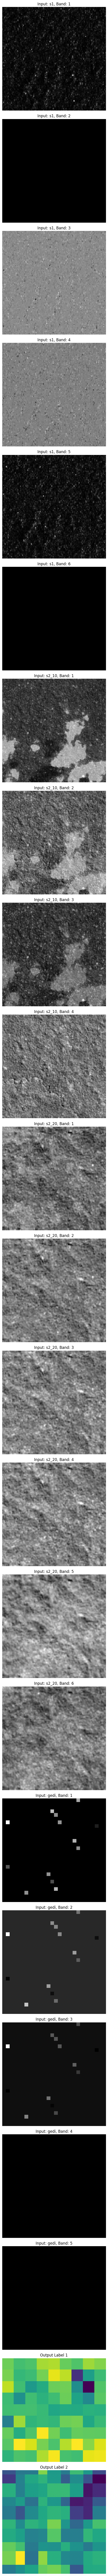

In [39]:
import matplotlib.pyplot as plt

# 假设 bands_count 已经根据实际情况定义，用于输入波段的计数
# label_dirs 用于定义输出标签，这里我们假设有2个输出
x, y = train_sequence[0]
# 计算绘图的总行数：所有输入的波段数 + 所有输出的数量
nrows = sum(bands_count.values()) + len(y)
ncols = 1  # 因为我们只查看第一个批次的数据

fig, axes = plt.subplots(nrows, ncols, figsize=(5, nrows*5))

current_row = 0
# 可视化每个输入图像的所有波段
for input_index, (input_key, band_count) in enumerate(bands_count.items()):
    for band_index in range(band_count):
        axes[current_row].imshow(x[input_index][0, :, :, band_index], cmap='gray')  # x[input_index]是当前输入类型的数据
        axes[current_row].axis('off')
        axes[current_row].set_title(f'Input: {input_key}, Band: {band_index + 1}')
        current_row += 1

# 可视化每个输出标签
for output_index in range(len(y)):
    axes[current_row].imshow(y[output_index][0, :, :, 0], cmap='viridis')  # y[output_index]是当前输出标签的数据
    axes[current_row].axis('off')
    axes[current_row].set_title(f'Output Label {output_index + 1}')
    current_row += 1

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import os
import keras.utils as kutils

class ValSequence(kutils.Sequence):
    def __init__(self, filenames, batch_size, patch_sizes, bands_count, label_dirs):
        self.filenames = filenames
        self.batch_size = batch_size
        self.patch_sizes = patch_sizes
        self.bands_count = bands_count
        self.label_dirs = label_dirs
        self.read_dataset()
        self.reset()

    def read_dataset(self):
        self.data = []
        min_patches_count = None

        for filename in self.filenames:
            # 读取和处理图像
            s1_image_path = os.path.join(S1_IMAGE_DIR, filename)
            s2_10_image_path = os.path.join(S2_10_IMAGE_DIR, filename)
            s2_20_image_path = os.path.join(S2_20_IMAGE_DIR, filename)
            gedi_image_path = os.path.join(GEDI_IMAGE_DIR, filename)
            
            #s1_image = read_and_preprocess_image(s1_image_path, normalise=True)
            s1_image = read_and_preprocess_image(s1_image_path, is_complex=True)

            # 然后处理其他图像，并使用S1图像作为模板
            s2_10_image = read_and_preprocess_image(s2_10_image_path)
            s2_20_image = read_and_preprocess_image(s2_20_image_path)
            gedi_image = read_and_preprocess_image(gedi_image_path)
            
            images = {'s1': s1_image, 's2_10': s2_10_image, 's2_20':s2_20_image, 'gedi': gedi_image}

            labels = {}
            for label_type in self.label_dirs:
                label_path = os.path.join(BASE_DIR, label_type, filename)
                label = read_single_band_image(label_path)
                labels[label_type] = label


            # Pad images and labels to their respective patch sizes
            for key in images:
                images[key], _ = pad_image_to_patch_size(images[key], self.patch_sizes[key])
            for key in labels:
                labels[key], _ = pad_image_to_patch_size(labels[key], self.patch_sizes[key])

            # Calculate patches count for each image and label, then update min_patches_count
            all_sizes = {**images, **labels}  # Combine images and labels for unified processing
            for key, item in all_sizes.items():
                patch_size = self.patch_sizes[key]
                patches_count = (item.shape[0] // patch_size[0]) * (item.shape[1] // patch_size[1])
                if min_patches_count is None or patches_count < min_patches_count:
                    min_patches_count = patches_count

            self.data.append((images, labels))

        self.len = min_patches_count * len(self.filenames) // self.batch_size

    def __len__(self):
        return self.len

    def sample_patch(self, image, patch_size):
        height, width, _ = image.shape
        x, y = np.random.randint(0, width - patch_size[1]), np.random.randint(0, height - patch_size[0])
        patch = image[y:y + patch_size[0], x:x + patch_size[1], :]
        return patch

    def __getitem__(self, idx):
        batch_x = {key: np.empty((self.batch_size, *self.patch_sizes[key], self.bands_count[key])) for key in ['s1', 's2_10', 's2_20', 'gedi']}
        batch_y = {key: np.empty((self.batch_size, *self.patch_sizes[key], 1)) for key in self.label_dirs}

        for i in range(self.batch_size):
            images, labels = self.data[idx % len(self.data)]
            for key in images:
                batch_x[key][i, ...] = self.sample_patch(images[key], self.patch_sizes[key])
            for key in labels:
                batch_y[key][i, ...] = self.sample_patch(labels[key], self.patch_sizes[key])

        return [batch_x[key] for key in batch_x], [batch_y[key] for key in batch_y]


    def sample_image(self):
        image_index = np.random.choice(len(self.data))
        return self.data[image_index]

    def reset(self):
        # Resets the sequence to the start
        self.image_index = 0


In [ ]:
val_sequence = ValSequence(VAL_IMAGES, BATCH_SIZE, patch_sizes, bands_count, label_dirs)

In [ ]:
# 设置输入尺寸
input_shape_s1 = 224,224,6  # Sentinel-1 输入尺寸
input_shape_s10 = 224,224,4  # Sentinel-2 输入尺寸
input_shape_s20 = 112,112,6  # Sentinel-2 输入尺寸
input_shape_gedi = 28, 28, 5  # GEDI 输入尺寸

In [ ]:
model = create_model(input_shape_s1, input_shape_s10, input_shape_s20, input_shape_gedi)

In [ ]:
model.summary()

In [ ]:
losses1 = {
    'output_250': 'mean_squared_error',  # 假设这是正确的层名称
    'output_100': 'mean_squared_error'   # 确保这里没有多余的空格
}
loss_weights1 = {
    'output_250': 0.8,
    'output_100': 0.2
}

In [ ]:
optimizer = keras.optimizers.Adam(0, clipnorm=1., epsilon=1e-4)
model.compile(optimizer=optimizer, loss=losses1, loss_weights=loss_weights1, metrics=['mse'])

In [ ]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [ ]:
history= model.fit(
    train_sequence, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    verbose=1, 
    validation_data=val_sequence
)

In [ ]:
# plot model training history
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# 绘制损失曲线
axs[0].set_title("Sample net training curve loss")
axs[0].plot(history.history["loss"], label="Train Loss")
axs[0].plot(history.history["val_loss"], label="Validation Loss")
axs[0].legend()
axs[0].set_ylabel("Loss")
axs[0].set_xlabel("Epoch")

# 绘制 MSE 曲线
axs[1].set_title("Sample net training curve MSE")
axs[1].plot(history.history["mse"], label="Train MSE")
axs[1].plot(history.history["val_mse"], label="Validation MSE")
axs[1].legend()
axs[1].set_ylabel("MSE")
axs[1].set_xlabel("Epoch")

plt.tight_layout()
plt.show()


In [ ]:
val_sequence.reset()

In [ ]:
test_sequence = ValSequence(TEST_IMAGES, BATCH_SIZE, patch_sizes, bands_count, ['LABEL_250_DIR', 'LABEL_100_DIR'])

In [ ]:
loss, mse = model.evaluate(test_sequence, verbose=0)
print(f"\nTest loss: {loss:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

In [ ]:
# save the weight of the trained network
model.save_weights("unet_weights.h5")

In [ ]:
def apply_biomass_estimation(image, regression_model, patch_size, step=！！！):
    original_height, original_width, _ = image.shape
    padded, (pad_height, pad_width) = pad_image_to_patch_size(image, patch_size)
    height, width, _ = padded.shape
    
    predictions = np.zeros((height, width))  # 单通道预测值
    
    row = 0
    while row + patch_size <= height:
        row_patches = []

        col = 0 
        while col + patch_size <= width:
            patch = padded[row:row + patch_size, col:col + patch_size, :]
            row_patches.append(patch)
            col += step

        batch = np.array(row_patches)
        row_predictions = regression_model.predict(batch, verbose=0)

        col, patch_idx = 0, 0
        while col + patch_size <= width:
            # 对于回归，我们可能直接取预测值而不是累加
            predictions[row:row + patch_size, col:col + patch_size] = \
                row_predictions[patch_idx].reshape(patch_size, patch_size)
            col += step
            patch_idx += 1

        row += step

    predictions = predictions[
        pad_height:pad_height + original_height,
        pad_width:pad_width + original_width
    ]
    
    return predictions


In [ ]:
SCENE_IDX = 0
image_path = os.path.join(IMAGE_DIR, VAL_IMAGES[SCENE_IDX])
label_path = os.path.join(LABEL_DIR, VAL_IMAGES[SCENE_IDX])

image = read_image(image_path, normalise=True)
label = map_classes(read_image(label_path))

prediction = apply_segmentation_with_fcn(image, model)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))

axs[0].imshow(image[:, :, [2, 1, 0]])
axs[0].set_title("Satellite image")
axs[1].imshow(label[:, :, 0])
axs[1].set_title("Groundtruth")
axs[2].imshow(prediction)
axs[2].set_title("U-Net prediction")

plt.tight_layout()
plt.show()

In [ ]:
SCENE_IDX = 1
image_path = os.path.join(IMAGE_DIR, VAL_IMAGES[SCENE_IDX])
label_path = os.path.join(LABEL_DIR, VAL_IMAGES[SCENE_IDX])

image = read_image(image_path, normalise=True)
label = map_classes(read_image(label_path))

prediction = apply_segmentation_with_fcn(image, model)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))

axs[0].imshow(image[:, :, [2, 1, 0]])
axs[0].set_title("Satellite image")
axs[1].imshow(label[:, :, 0])
axs[1].set_title("Groundtruth")
axs[2].imshow(prediction)
axs[2].set_title("U-Net prediction")

plt.tight_layout()
plt.show()